# Setup Iniziale




1.   Attivare il supporto GPU in Runtime->Change Runtime Type->Hardware Accelerator
2.   Check if pyCUDA è installato



In [ ]:
!pip install pycuda
import pycuda

# Esplorare la Bash

In [ ]:
!ls
!pwd                 #Show position
!cd ..

In [ ]:
!mkdir test_d       #Make directory
!rm -r test_dir/    #Remove directory (-d if empty)

In [7]:
!touch ciao         #Create empty file
!rm ciao

In [ ]:
!gcc --version
!nvcc --version     #Controlla la versione di CUDA installata

Look at the following link for more information:
https://wiki.ubuntu-it.org/Programmazione/LinguaggioBash

# Caratteristiche della GPU in uso

Proviamo a capire le caratteristiche della GPU che abbiamo a disposizione.


In [10]:
!nvidia-smi

Thu Nov 19 19:26:44 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P8     9W /  70W |     10MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

oppure si può usare il modulo pycuda, interrogando le funzioni del driver

In [9]:
import pycuda.driver as drv
drv.init()
drv.get_version()
devn=drv.Device.count()
print("N GPU "+str(devn))
devices = []
for i in range(devn):
  devices.append(drv.Device(i))
for sp in devices:
  print("GPU name: "+str(sp.name))
  print("Compute Capability = "+str(sp.compute_capability()))
  print("Total Memory = "+str(sp.total_memory()/(2.**20))+' MBytes')
  attr = sp.get_attributes()
  print(attr)

N GPU 1
GPU name: <bound method name of <pycuda._driver.Device object at 0x7f48604878b8>>
Compute Capability = (7, 5)
Total Memory = 15079.75 MBytes
{pycuda._driver.device_attribute.ASYNC_ENGINE_COUNT: 3, pycuda._driver.device_attribute.CAN_MAP_HOST_MEMORY: 1, pycuda._driver.device_attribute.CLOCK_RATE: 1590000, pycuda._driver.device_attribute.COMPUTE_CAPABILITY_MAJOR: 7, pycuda._driver.device_attribute.COMPUTE_CAPABILITY_MINOR: 5, pycuda._driver.device_attribute.COMPUTE_MODE: pycuda._driver.compute_mode.DEFAULT, pycuda._driver.device_attribute.CONCURRENT_KERNELS: 1, pycuda._driver.device_attribute.ECC_ENABLED: 1, pycuda._driver.device_attribute.GLOBAL_L1_CACHE_SUPPORTED: 1, pycuda._driver.device_attribute.GLOBAL_MEMORY_BUS_WIDTH: 256, pycuda._driver.device_attribute.GPU_OVERLAP: 1, pycuda._driver.device_attribute.INTEGRATED: 0, pycuda._driver.device_attribute.KERNEL_EXEC_TIMEOUT: 0, pycuda._driver.device_attribute.L2_CACHE_SIZE: 4194304, pycuda._driver.device_attribute.LOCAL_L1_CACHE_

oppure anche con il metodo DeviceData()

In [13]:
from pycuda import autoinit
from pycuda.tools import DeviceData
specs = DeviceData()
print ('Max threads per block = '+str(specs.max_threads))
print ('Warp size            ='+str(specs.warp_size))
print ('Warps per MP         ='+str(specs.warps_per_mp))
print ('Thread Blocks per MP ='+str(specs.thread_blocks_per_mp))
print ('Registers            ='+str(specs.registers))
print ('Shared memory        ='+str(specs.shared_memory))

Max threads per block = 1024
Warp size            =32
Warps per MP         =64
Thread Blocks per MP =8
Registers            =65536
Shared memory        =49152


# Esempio GPU in C
Proviamo a scrivere e compilare un programma GPU in C. Notare il comando (magic) all'inizio che serve per salvare il contenuto della cella in un file nel workspace.

In [11]:
%%writefile VecAdd.cu
# include <stdio.h>
# include <cuda_runtime.h>

// CUDA Kernel
__global__ void vectorAdd(const float *A, const float *B, float *C, int numElements)
{
    int i = blockDim.x * blockIdx.x + threadIdx.x;
    if (i < numElements)
    {
        C[i] = A[i] + B[i];
    }
}
 
/**
 * Host main routine
 */

int main(void)
{
    int numElements = 15;
    size_t size = numElements * sizeof(float);
    printf("[Vector addition of %d elements]\n", numElements);
 
    float a[numElements],b[numElements],c[numElements];
    float *a_gpu,*b_gpu,*c_gpu;
 
    // Generates the input vectors
    for (int i=0;i<numElements;++i){
        a[i] = i*i;
        b[i] = i;
    }
 
    // Allocate space on the GPU 
    cudaMalloc((void **)&a_gpu, size);
    cudaMalloc((void **)&b_gpu, size);
    cudaMalloc((void **)&c_gpu, size);
 
    // Copy vectors A and B in host memory to the device vectors in device memory
    printf("Copy input data from the host memory to the CUDA device\n");
    cudaMemcpy(a_gpu, a, size, cudaMemcpyHostToDevice);
    cudaMemcpy(b_gpu, b, size, cudaMemcpyHostToDevice);
 
    // Launch the Vector Add CUDA Kernel
    int threadsPerBlock = 256;
    int blocksPerGrid = (numElements + threadsPerBlock - 1) / threadsPerBlock;
    printf("CUDA kernel launch with %d blocks of %d threads\n", blocksPerGrid, threadsPerBlock);
    vectorAdd<<<blocksPerGrid, threadsPerBlock>>>(a_gpu, b_gpu, c_gpu, numElements);
 
    // Copy the device result vectors to the host result vectors in host memory
    printf("Copy output data from the CUDA device to the host memory\n");
    cudaMemcpy(c, c_gpu, size, cudaMemcpyDeviceToHost);
 
    // Free device global memory
    cudaFree(a_gpu);
    cudaFree(b_gpu);
    cudaFree(c_gpu);

    for (int i=0;i<numElements;++i ){
        printf("%f \n", c[i]);
    }
 
    printf("Done\n");
    return 0;
}


Writing VecAdd.cu


In [12]:
!ls
!nvcc -o VecAdd VecAdd.cu
!./VecAdd

drive			handson_gpu_2020.pdf  test_d
handson_gpu_2020.ipynb	sample_data	      VecAdd.cu
[Vector addition of 15 elements]
Copy input data from the host memory to the CUDA device
CUDA kernel launch with 1 blocks of 256 threads
Copy output data from the CUDA device to the host memory
0.000000 
2.000000 
6.000000 
12.000000 
20.000000 
30.000000 
42.000000 
56.000000 
72.000000 
90.000000 
110.000000 
132.000000 
156.000000 
182.000000 
210.000000 
Done


# Implementazione con pycuda


In [14]:
from pycuda import autoinit
from pycuda import gpuarray
import numpy as np

In [15]:
#Generating some initial vectors

aux = range(15)
a = np.array(aux).astype(np.float32)
b = (a*a).astype(np.float32)
c = np.zeros(len(aux)).astype(np.float32)

# Creating copies of the initial vectors on the GPU 

a_gpu = gpuarray.to_gpu(a)
b_gpu = gpuarray.to_gpu(b)
c_gpu = gpuarray.to_gpu(c)

A.) Modo semplice per operare sui vettori della GPU.

In [16]:
c_gpu = a_gpu + b_gpu
print(c_gpu)

[  0.   2.   6.  12.  20.  30.  42.  56.  72.  90. 110. 132. 156. 182.
 210.]


B.) Il secondo modo è quello di utilizzare il metodo elementwise, che applica la stessa "Operation" a tutti gli elementi dei vettori. Il vantaggio è che si possono definire anche operazioni piu' complesse della semplice somma.

In [17]:
from pycuda.elementwise import ElementwiseKernel
myCudaFunc = ElementwiseKernel(arguments = "float *a, float *b, float *c",
                               operation = "c[i] = a[i]+b[i]",
                               name = "mySumK")
myCudaFunc(a_gpu,b_gpu,c_gpu)
c_gpu

array([  0.,   2.,   6.,  12.,  20.,  30.,  42.,  56.,  72.,  90., 110.,
       132., 156., 182., 210.], dtype=float32)

Altro esempio di operazione tra vettori con Pycuda.

In [18]:
from pycuda.elementwise import ElementwiseKernel
lin_comb = ElementwiseKernel(
        "float a, float *x, float b, float *y, float *z",
        "z[i] = a*x[i] + b*y[i]",
        "linear_combination")
lin_comb(3.,a_gpu,5.,b_gpu,c_gpu)
c_gpu

array([   0.,    8.,   26.,   54.,   92.,  140.,  198.,  266.,  344.,
        432.,  530.,  638.,  756.,  884., 1022.], dtype=float32)

C.) Il terzo modo è il piu' "generico". Si utilizza il metodo SourceModule che permette di definire anche kernel piu' complessi.
Con questo modulo si possono importare metodi da file scritti in C.

In [20]:
from pycuda.compiler import SourceModule

!ls

# Nella stessa cartella del file in C o inserendo il percorso
cudaCode = open("VecAdd.cu","r")
code = cudaCode.read()
myCode = SourceModule(code)                       # Compile the file
importedKernel = myCode.get_function("vectorAdd") # Import of the needed module

drive			handson_gpu_2020.pdf  test_d  VecAdd.cu
handson_gpu_2020.ipynb	sample_data	      VecAdd


definiamo la "geometria" della GPU che vogliamo usare e resettiamo il vettore c_gpu (per essere sicuri sia vuoto)

In [21]:
nThreadsPerBlock = 256
nBlockPerGrid = 1
nGridsPerBlock = 1

c_gpu.set(c)
c_gpu

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

lanciamo il kernel importato passandogli i puntatori dei vettori e la geometria della GPU

In [22]:
b_gpu.gpudata # restituisce il puntatore nella memoria gpu
importedKernel(a_gpu.gpudata, b_gpu.gpudata, c_gpu.gpudata, 
               block=(nThreadsPerBlock,nBlockPerGrid,nGridsPerBlock))
print(c_gpu)

[  0.   2.   6.  12.  20.  30.  42.  56.  72.  90. 110. 132. 156. 182.
 210.]


# Somma di Matrici

In [23]:
# Puliamo la memoria
%reset

import numpy as np
from pycuda import gpuarray, autoinit
import pycuda.driver as cuda
from pycuda.tools import DeviceData
from pycuda.tools import OccupancyRecord as occupancy
from matplotlib import pyplot as plt

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


inizializziamo gli array con le dimensioni appropriate e copiamolo sulla gpu

In [24]:
N = 512
presCPU, presGPU = np.float32, 'float'
#presCPU, presGPU = np.float64, 'double'
a_cpu = np.random.random((N,N)).astype(presCPU)
b_cpu = np.random.random((N,N)).astype(presCPU)
c_cpu = np.zeros((N,N), dtype=presCPU)

a_gpu = gpuarray.to_gpu(a_cpu)
b_gpu = gpuarray.to_gpu(b_cpu)
c_gpu = gpuarray.to_gpu(c_cpu)

misuriamo il tempo che ci vuole sull'host per fare la somma

In [26]:
t_cpu = %timeit -o c_cpu = a_cpu + b_cpu
c_cpu = a_cpu + b_cpu

10000 loops, best of 3: 166 µs per loop


definiamo il kernel gpu per fare la somma e compilamolo per generare la funzione da usare in python

In [27]:
from pycuda.compiler import SourceModule

cudaKernel = """
__global__ void matrixAdd(float *A, float *B, float *C)
{
    int tid_x = blockDim.x * blockIdx.x + threadIdx.x;
    int tid_y = blockDim.y * blockIdx.y + threadIdx.y;
    int tid   = gridDim.x * blockDim.x * tid_y + tid_x;
    C[tid] = A[tid] + B[tid];
}
"""
myCode = SourceModule(cudaKernel)
addMatrix = myCode.get_function("matrixAdd") 
# The output of get_function is the GPU-compiled function.

Per decidere la geoemtria della GPU, vediamo quanti thread ci sono in un blocco.

In [28]:
dev = cuda.Device(0)
devdata = DeviceData(dev)
print ("Using device : "+dev.name() )
print("Max threads per block: "+str(dev.max_threads_per_multiprocessor))

Using device : Tesla T4
Max threads per block: 1024


Quindi possiamo usare blocchi 32x32. Le nostre matrici sono 512x512, per cui dobbiamo usare 16x16 blocchi

In [29]:
cuBlock = (32,32,1)
cuGrid = (16,16,1)

abbiamo già compilato il kernel con SourceModule. Ora abbiamo due modi per lanciarlo. O chiamiamo direttamente la funzione (come abbiamo fatto sopra per la somam di vettori)
```
kernelFunction(arg1,arg2, ... ,block=(n,m,l),grid=(r,s,t)
```
oppure usiamo la "preparation"


```
kernelFunction.prepare('ABC..') 
# Each letter corresponds to an input data type of the function, i = int, f = float, P = pointer, ...
kernelFunction.prepared_call(grid,block,arg1.gpudata,arg2,...) 
# When using GPU arrays, they should be passed as pointers with the attribute 'gpudata'
```

con la preparation è possibile misurare il tempo di esecuzione.

In [30]:
addMatrix(a_gpu, b_gpu, c_gpu, block=cuBlock, grid=cuGrid)

addMatrix.prepare('PPP')
addMatrix.prepared_call(cuGrid,cuBlock,a_gpu.gpudata,b_gpu.gpudata,c_gpu.gpudata)
c = c_gpu.get()

In [31]:
time2 = addMatrix.prepared_timed_call(cuGrid,cuBlock,a_gpu.gpudata,b_gpu.gpudata,c_gpu.gpudata)
time2()

3.897599875926972e-05

per confrontare meglio, guardiamo i plot e la somma degli scarti

0.0

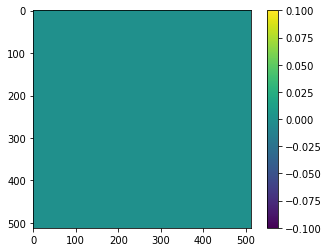

In [33]:
plt.imshow(c_cpu - c, interpolation='none')
plt.colorbar()

np.sum(np.abs(c_cpu - c))

# Moltiplicazione tra matrici

scriviamo un kernel per la moltiplicazione di matrici

In [34]:
cudaKernel2 = '''
__global__ void matrixMul(float *A, float *B, float *C)
{
    int tid_x = blockDim.x * blockIdx.x + threadIdx.x; // Row
    int tid_y = blockDim.y * blockIdx.y + threadIdx.y; // Column
    int matrixDim = gridDim.x * blockDim.x;
    int tid   = matrixDim * tid_y + tid_x; // element i,j
    
    float  aux=0.0f;
    
    for ( int i=0 ; i<matrixDim ; i++ ){
        //          
        aux += A[matrixDim * tid_y + i]*B[matrixDim * i + tid_x] ;
    
    }
    
    C[tid] = aux;
             
}
'''

compiliamo e importiamo con SourceModule

In [35]:
myCode = SourceModule(cudaKernel2)
mulMatrix = myCode.get_function("matrixMul")

eseguiamolo con la stessa struttura a blocchi definite per la somma di matrici

In [36]:
mulMatrix(a_gpu,b_gpu,c_gpu,block=cuBlock,grid=cuGrid)
cc = c_gpu.get()
cc

array([[118.96796 , 128.53334 , 137.8951  , ..., 136.81343 , 133.89436 ,
        127.94641 ],
       [122.9554  , 133.81279 , 143.96031 , ..., 141.14583 , 136.77325 ,
        130.43245 ],
       [112.57934 , 127.36276 , 133.96962 , ..., 134.69655 , 126.64585 ,
        126.39626 ],
       ...,
       [119.63033 , 126.494354, 133.07224 , ..., 135.8559  , 132.20541 ,
        124.66109 ],
       [119.22459 , 129.37212 , 137.39934 , ..., 140.91711 , 131.36617 ,
        129.44757 ],
       [114.62997 , 127.02198 , 133.08858 , ..., 132.60606 , 128.43506 ,
        125.69298 ]], dtype=float32)

sulla CPU sarà invece

In [37]:
dotAB = np.dot(a_cpu, b_cpu)
dotAB

array([[118.96799 , 128.53336 , 137.89502 , ..., 136.8135  , 133.89429 ,
        127.94642 ],
       [122.955475, 133.81274 , 143.96027 , ..., 141.1458  , 136.77321 ,
        130.43245 ],
       [112.579315, 127.362755, 133.96964 , ..., 134.69649 , 126.64586 ,
        126.39632 ],
       ...,
       [119.630356, 126.49432 , 133.0722  , ..., 135.85583 , 132.20549 ,
        124.66108 ],
       [119.22464 , 129.37212 , 137.39932 , ..., 140.91711 , 131.36627 ,
        129.4476  ],
       [114.63002 , 127.02196 , 133.0886  , ..., 132.60608 , 128.43506 ,
        125.69298 ]], dtype=float32)

vediamo che il risultato è lo stesso a meno di errore numerico

In [44]:
diff = np.abs(cc-dotAB)
err = np.sum(diff)/np.min(np.abs(cc))
print(err)

0.08186958


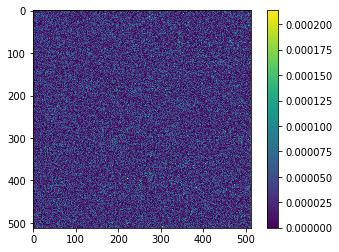

In [39]:
plt.imshow(diff,interpolation='none')
plt.colorbar()

In [45]:
presCPU, presGPU = np.float64, 'double'
a_cpu = np.random.random((512,512)).astype(presCPU)
b_cpu = np.random.random((512,512)).astype(presCPU)
c_cpu = np.zeros((512,512), dtype=presCPU)

In [46]:
a_gpu = gpuarray.to_gpu(a_cpu)
b_gpu = gpuarray.to_gpu(b_cpu)
c_gpu = gpuarray.to_gpu(c_cpu)

In [48]:
cudaKernel3 = '''
__global__ void matrixMul64(double *A, double *B, double *C)
{
    int tid_x = blockDim.x * blockIdx.x + threadIdx.x; // Row
    int tid_y = blockDim.y * blockIdx.y + threadIdx.y; // Column
    int matrixDim = gridDim.x * blockDim.x;
    int tid   = matrixDim * tid_y + tid_x; // element i,j
    
    double aux = 0.0;
    for ( int i=0 ; i<matrixDim ; i++ ){
        //          
        aux += A[matrixDim * tid_y + i]*B[matrixDim * i + tid_x] ;
    
    }
    
    C[tid] = aux;
             
}
'''

In [49]:
myCode64 = SourceModule(cudaKernel3)
mulMatrix64 = myCode64.get_function("matrixMul64")

In [50]:
mulMatrix64(a_gpu,b_gpu,c_gpu,block=cuBlock,grid=cuGrid)

In [51]:
dotAB = np.dot(a_cpu, b_cpu)

In [52]:
diff = np.abs(c_gpu.get()-dotAB)

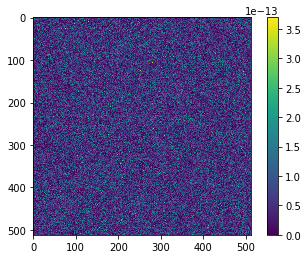

In [53]:
plt.imshow(diff,interpolation='none')
plt.colorbar()

# Ancora sulla somma di vettori

In [54]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


Vogliamo confrontare i tempi per la somma di vettori di dimensione variabile, tra CPU e GPU

Iniziamo con la versione CPU

In [55]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from time import time
def myColorRand():
    return (np.random.random(),np.random.random(),np.random.random())

In [56]:
dimension = [2**i for i in range(5,25) ]
myPrec = np.float32
print(dimension)

[32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768, 65536, 131072, 262144, 524288, 1048576, 2097152, 4194304, 8388608, 16777216]


In [57]:
nLoops = 100
timeCPU = []
for n in dimension:
    v1_cpu = np.random.random(n).astype(myPrec)
    v2_cpu = np.random.random(n).astype(myPrec)
    tMean = 0
    for i in range(nLoops):
        t = time() 
        v = v1_cpu+v2_cpu
        t = time() - t
        tMean += t/nLoops
    timeCPU.append(tMean)

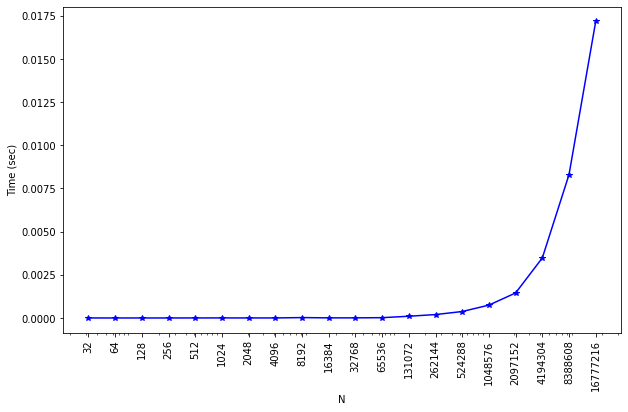

In [58]:
plt.figure(1,figsize=(10,6))
plt.semilogx(dimension,timeCPU,'b-*')
plt.ylabel('Time (sec)')
plt.xlabel('N')
plt.xticks(dimension, dimension, rotation='vertical')
plt.show()

Proviamo a fare la versione GPU.
Per prima cosa guardiamo la semplice somma (primo metodo)

In [59]:
import pycuda
from pycuda import gpuarray

In [60]:
timeGPU1 = []
bandWidth1 = []
for n in dimension:
    v1_cpu = np.random.random(n).astype(myPrec)
    v2_cpu = np.random.random(n).astype(myPrec)
    t1Mean = 0
    t2Mean = 0
    for i in range(nLoops):
        t = time()
        vaux = gpuarray.to_gpu(v1_cpu)
        t = time() -t
        t1Mean += t/nLoops
    bandWidth1.append(t1Mean)
    v1_gpu = gpuarray.to_gpu(v1_cpu) 
    v2_gpu = gpuarray.to_gpu(v2_cpu)
    for i in range(nLoops):
        t = time()
        v = v1_gpu+v2_gpu
        t = time() -t
        t2Mean += t/nLoops
    timeGPU1.append(t2Mean)
    v1_gpu.gpudata.free()
    v2_gpu.gpudata.free()
    v.gpudata.free()

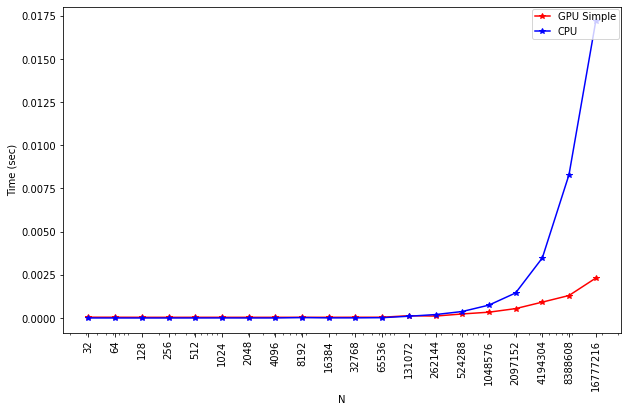

In [61]:
plt.figure(1,figsize=(10,6))
plt.semilogx(dimension,timeGPU1,'r-*',label='GPU Simple')
plt.semilogx(dimension,timeCPU,'b-*',label='CPU')
plt.ylabel('Time (sec)')
plt.xlabel('N')
plt.xticks(dimension, dimension, rotation='vertical')
plt.legend(loc=1,labelspacing=0.5,fancybox=True, handlelength=1.5, borderaxespad=0.25, borderpad=0.25)
plt.show()

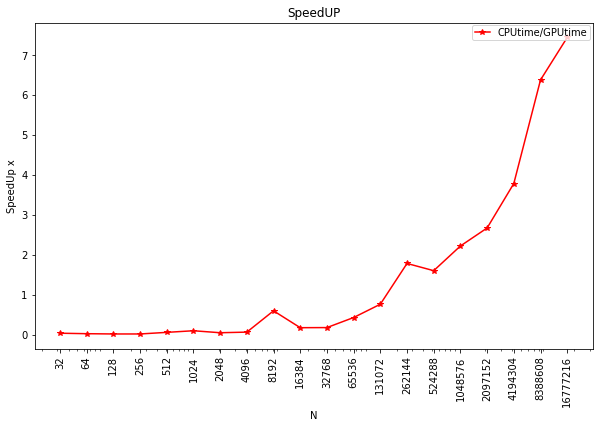

In [62]:
plt.figure(1,figsize=(10,6))

a = np.array(timeGPU1)
b = np.array(timeCPU)
plt.semilogx(dimension,b/a,'r-*',label='CPUtime/GPUtime')
plt.ylabel('SpeedUp x')
plt.xlabel('N')
plt.title('SpeedUP')
plt.xticks(dimension, dimension, rotation='vertical')
plt.legend(loc=1,labelspacing=0.5,fancybox=True, handlelength=1.5, borderaxespad=0.25, borderpad=0.25)
plt.show()

proviamo anche a valutare il tempo di trasferimento su GPU

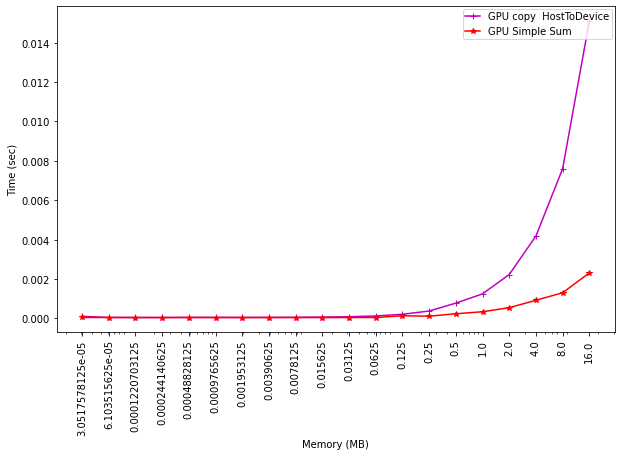

In [63]:
plt.figure(1,figsize=(10,6))
sizeMB = np.array(dimension)/(2.**20)
plt.semilogx(sizeMB,bandWidth1,'m-+',label='GPU copy  HostToDevice')
plt.semilogx(sizeMB,timeGPU1,'r-*',label='GPU Simple Sum')
plt.ylabel('Time (sec)')
plt.xlabel('Memory (MB)')
plt.xticks(sizeMB, sizeMB, rotation='vertical')
plt.legend(loc=1,labelspacing=0.5,fancybox=True, handlelength=1.5, borderaxespad=0.25, borderpad=0.25)
plt.show()

proviamo ad usare elementwise (secondo metodo)

In [64]:
from pycuda.elementwise import ElementwiseKernel
myCudaFunc = ElementwiseKernel(arguments = "float *a, float *b, float *c",
                               operation = "c[i] = a[i]+b[i]",
                               name = "mySumK")

In [65]:
import pycuda.driver as drv
start = drv.Event()
end = drv.Event()

In [66]:
timeGPU2 = []
for n in dimension:
    v1_cpu = np.random.random(n).astype(myPrec)
    v2_cpu = np.random.random(n).astype(myPrec)
    v1_gpu = gpuarray.to_gpu(v1_cpu) 
    v2_gpu = gpuarray.to_gpu(v2_cpu)
    vr_gpu  = gpuarray.to_gpu(v2_cpu)
    t3Mean=0
    for i in range(nLoops):
        start.record()
        myCudaFunc(v1_gpu,v2_gpu,vr_gpu)
        end.record()
        end.synchronize()
        secs = start.time_till(end)*1e-3
        t3Mean+=secs/nLoops
    timeGPU2.append(t3Mean)
    v1_gpu.gpudata.free()
    v2_gpu.gpudata.free()
    vr_gpu.gpudata.free()

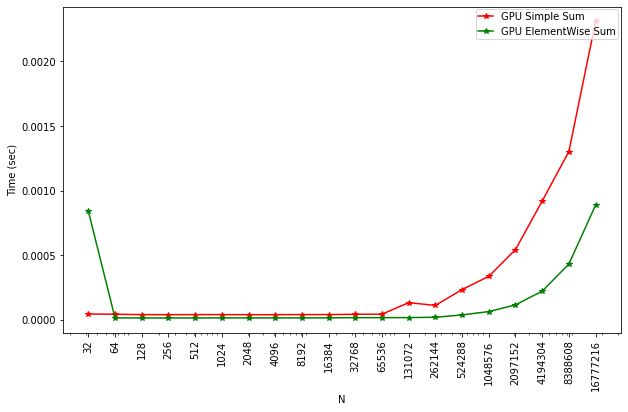

In [67]:
plt.figure(1,figsize=(10,6))
plt.semilogx(dimension,timeGPU1,'r-*',label='GPU Simple Sum')
plt.semilogx(dimension,timeGPU2,'g-*',label='GPU ElementWise Sum')
plt.ylabel('Time (sec)')
plt.xlabel('N')
plt.xticks(dimension, dimension, rotation='vertical')
plt.legend(loc=1,labelspacing=0.5,fancybox=True, handlelength=1.5, borderaxespad=0.25, borderpad=0.25)

Implementazione con SourceModule. E' possibile variare la geometria di griglia e blocchi

In [68]:
from pycuda.compiler import SourceModule

In [ ]:
presCPU, presGPU = np.float32, 'float'
cudaCode = open("VecAdd.cu","r")
cudaCode = cudaCode.read()
cudaCode = cudaCode.replace('float',presGPU )
myCode = SourceModule(cudaCode)
vectorAddKernel = myCode.get_function("vectorAdd")
vectorAddKernel.prepare('PPP')

In [ ]:
timeGPU3 = []
occupancyMesure=[]
for nt in [32,64,128,256,512,1024]:
    aux = []
    auxOcc = []
    for n in dimension:
        v1_cpu = np.random.random(n).astype(myPrec)
        v2_cpu = np.random.random(n).astype(myPrec)
        v1_gpu = gpuarray.to_gpu(v1_cpu) 
        v2_gpu = gpuarray.to_gpu(v2_cpu)
        vr_gpu  = gpuarray.to_gpu(v2_cpu)
        cudaBlock = (nt,1,1) 
        cudaGrid    = (int((n+nt-1)/nt),1,1)
        
        cudaCode = open("VecAdd.cu","r")
        cudaCode = cudaCode.read()
        cudaCode = cudaCode.replace('float',presGPU )
        downVar = ['blockDim.x','blockDim.y','blockDim.z','gridDim.x','gridDim.y','gridDim.z']
        upVar      = [str(cudaBlock[0]),str(cudaBlock[1]),str(cudaBlock[2]),
                     str(cudaGrid[0]),str(cudaGrid[1]),str(cudaGrid[2])]
        dicVarOptim = dict(zip(downVar,upVar))
        for i in downVar:
            cudaCode = cudaCode.replace(i,dicVarOptim[i])
        #print cudaCode
        myCode = SourceModule(cudaCode)
        vectorAddKernel = myCode.get_function("vectorAdd")
        vectorAddKernel.prepare('PPP')
        
        print ('Size= '+str(n)+" threadsPerBlock= "+str(nt))
        print (str(cudaBlock)+" "+str(cudaGrid))
        t5Mean = 0
        for i in range(nLoops):
            timeAux = vectorAddKernel.prepared_timed_call(cudaGrid,cudaBlock,v1_gpu.gpudata,v2_gpu.gpudata,vr_gpu.gpudata)
            t5Mean += timeAux()/nLoops
        aux.append(t5Mean)
        v1_gpu.gpudata.free()
        v2_gpu.gpudata.free()
        vr_gpu.gpudata.free()
    timeGPU3.append(aux)
    occupancyMesure.append(auxOcc)

In [ ]:
timeGPU3[0]

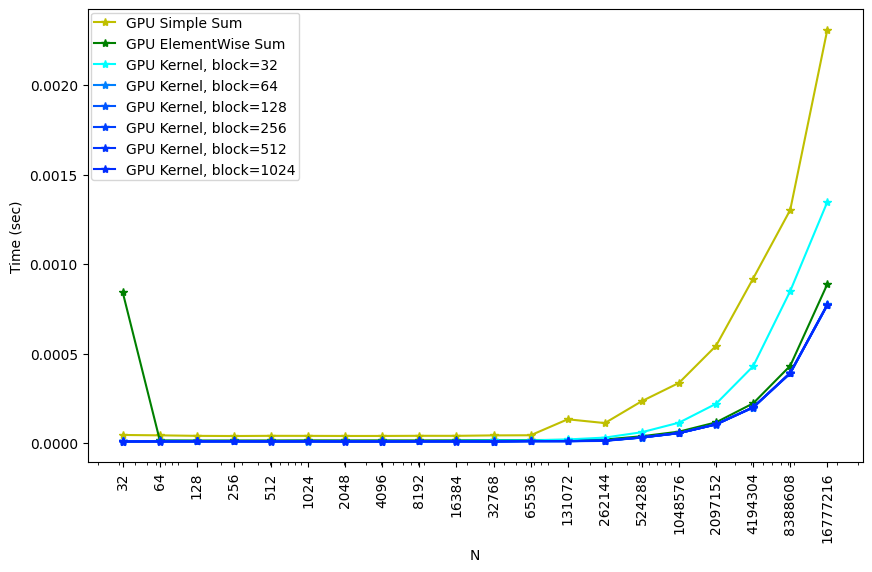

In [72]:
plt.figure(1,figsize=(10,6),dpi=100)
plt.semilogx(dimension,timeGPU1,'y-*',label='GPU Simple Sum')
plt.semilogx(dimension,timeGPU2,'g-*',label='GPU ElementWise Sum')
count = 0
for nt in [32,64,128,256,512,1024]:
    plt.semilogx(dimension,timeGPU3[count],'-*',label='GPU Kernel, block={0}'.format(nt),color=(0,1./(count+1),1))
    count+=1
plt.ylabel('Time (sec)')
plt.xlabel('N')
plt.xticks(dimension, dimension, rotation='vertical')
plt.legend(loc=2,labelspacing=0.5,fancybox=True, handlelength=1.5, borderaxespad=0.25, borderpad=0.25)

# Generare il PDF del Notebook

In [ ]:
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc

si deve montare il proprio google drive (seguire il link per ottenere la chiave di accesso)

In [74]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


si deve copiare il notebook nella directory della macchina virtuale

In [75]:
!cp "drive/My Drive/Colab Notebooks/handson_gpu_2020.ipynb" ./

ora si puo' convertire in pdf

In [ ]:
!jupyter nbconvert --to PDF "handson_gpu_2020.ipynb"

scaricare il file pdf prodotto dal menu files nel pannelo di sinistra (premere il destro sul file e fare download)